In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from brukeropusreader import read_file
from scipy.interpolate import interp1d
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2




In [2]:


# Define folder paths (corrected paths for RE and OE)
folder_path_oe = 'Spectra RE'  # OE data actually in 'Spectra RE'
folder_path_re = 'Spectra OE'  # RE data actually in 'Spectra OE'
folder_path_trachea = 'Spectra TR'  # Trachea data is correct

# Function to list files in a folder
def list_files(folder_path):
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    return files

# List files in each folder
files_re = list_files(folder_path_re)  # Actually RE data in 'Spectra OE'
files_oe = list_files(folder_path_oe)  # Actually OE data in 'Spectra RE'
files_tr = list_files(folder_path_trachea)  # Trachea data in 'Spectra TR'

# Displaying file names and their count
print("RE Folder:")
print(f"Number of files: {len(files_re)}")
print("Files:", files_re)

print("\nOE Folder:")
print(f"Number of files: {len(files_oe)}")
print("Files:", files_oe)

print("\nTrachea Folder:")
print(f"Number of files: {len(files_tr)}")
print("Files:", files_tr)



RE Folder:
Number of files: 185
Files: ['20240408 A5 OE.0004', '20240408 A5 OE.0003', '20240408 A2 OE.0001', '20240311 OE 1.0003', '19022024 OE 4.0004', '05022024 OE 1 mit max druck.0004', '20240415 B5 OE.0002', '20240415 B2 OE.0000', '20240311 OE 1.0004', '05022024 OE 1 mit max druck.0003', '20240318 OE A2.0000', '20240311 OE 5.0001', '19022024 OE 4.0003', '20240304 OE 3.0000', '20240408 A5 OE.0002', '20240408 A2 OE.0000', '20240304 OE 3.0001', '20240311 OE 5.0000', '19022024 OE 4.0002', '20240318 OE A2.0001', '05022024 OE 1 mit max druck.0002', '20240415 B5 OE.0004', '20240311 OE 1.0002', '20240415 B5 OE.0003', '20240415 B2 OE.0001', '19022024 OE 1.0000', '19022024 OE 5.0002', '20240318 OE A3.0001', '05022024 OE 2 mit max druck.0002', '05022024 OE 5 mit max druck.0000', '20240408 A3 OE.0000', '20240408 A4 OE.0002', '20240304 OE 2.0001', '20240415 B3 OE.0001', '20240415 B4 OE.0003', '20240415 B4 OE.0004', '20240408 A3 OE.0001', '20240408 A4 OE.0003', '05022024 OE 5 mit max druck.0001'

In [3]:

# Define the common set of wavenumbers
start_wavenumber = 5000  # Starting wavenumber
end_wavenumber = 400  # Ending wavenumber
resolution = 1  # Resolution in cm⁻¹

# Generate the common set of wavenumbers
common_wavenumbers = np.arange(start_wavenumber, end_wavenumber - resolution, -resolution)

# Verify the first and last values as well as the size of the set to ensure it matches expectations
print("First wavenumber:", common_wavenumbers[0])
print("Last wavenumber:", common_wavenumbers[-1])
print("Total number of points:", len(common_wavenumbers))

def get_wavenumbers(file_path):
    opus_data = read_file(file_path)
    num_points = len(opus_data['AB'])
    start_wn = opus_data['AB Data Parameter']['FXV']
    end_wn = opus_data['AB Data Parameter']['LXV']
    wavenumbers = np.linspace(start_wn, end_wn, num_points)
    return wavenumbers

def get_spectral_data(file_path):
    opus_data = read_file(file_path)
    spectral_data = opus_data['AB']
    return spectral_data

def interpolate_to_common_wavenumbers(file_path, common_wavenumbers):
    original_wavenumbers = get_wavenumbers(file_path)
    original_data = get_spectral_data(file_path)
    interpolation_func = interp1d(original_wavenumbers, original_data, kind='linear', fill_value="extrapolate")
    interpolated_data = interpolation_func(common_wavenumbers)
    return interpolated_data

def z_score_normalize(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    normalized_data = (data - mean) / std_dev
    return normalized_data

def process_directory(folder_path, common_wavenumbers):
    normalized_data_list = []
    files = list_files(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        data = interpolate_to_common_wavenumbers(file_path, common_wavenumbers)
        mask = (common_wavenumbers >= 900) & (common_wavenumbers <= 1800)
        data = data[mask]
        normalized_data = z_score_normalize(data)
        normalized_data_list.append(normalized_data)
    return np.array(normalized_data_list)

# Process directories
data_oe = process_directory(folder_path_oe, common_wavenumbers)
data_re = process_directory(folder_path_re, common_wavenumbers)
data_trachea = process_directory(folder_path_trachea, common_wavenumbers)


First wavenumber: 5000
Last wavenumber: 400
Total number of points: 4601


In [5]:
# Combine the average spectral data into one dataset and create labels
X = np.vstack([data_oe, data_re, data_trachea])
y = np.array([0] * len(data_oe) + [1] * len(data_re) + [2] * len(data_trachea))
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 293
Validation set size: 98
Test set size: 98


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Hyperparameters
neurons_per_layer = 320
num_layers = 4
dropout_rate = 0.2
initializer = tf.keras.initializers.HeNormal()
l1_lambda = 0.00036499
l2_lambda = 0.0008163
learning_rate = 0.00013516

# Build the model with the specified hyperparameters
def create_ffnn_model(input_shape):
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=input_shape))
    model.add(Dense(neurons_per_layer, activation='relu', kernel_initializer=initializer, 
                    kernel_regularizer=l1_l2(l1_lambda, l2_lambda)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Hidden layers
    for _ in range(num_layers - 1):
        model.add(Dense(neurons_per_layer, activation='relu', kernel_initializer=initializer, 
                        kernel_regularizer=l1_l2(l1_lambda, l2_lambda)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    # Output layer (3 classes: OE, RE, TR)
    model.add(Dense(3, activation='softmax'))  # Assuming 3 classes for OE, RE, TR

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Assuming X_train has already been defined
input_shape = (X_train.shape[1],)  # Define input shape based on your data
model = create_ffnn_model(input_shape)

# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7)

# If you want to define class weights (optional)
# Example class_weights based on class imbalance, adjust these values to your data
# class_weights = {0: 1.0, 1: 1.0, 2: 1.0}

# Train the model with the specified hyperparameters and callbacks
history = model.fit(X_train, y_train, epochs=600, validation_data=(X_val, y_val), batch_size=64, 
                    verbose=1, callbacks=[early_stopping, lr_scheduler])  # Remove class_weight if not needed

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Loss: {test_loss}')

# Predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate classification report (includes precision, recall, f1-score, and support)
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=["OE", "RE", "TR"]))

# Confusion Matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["OE", "RE", "TR"], yticklabels=["OE", "RE", "TR"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate F1-Score, Precision, and Recall
f1 = f1_score(y_true, y_pred_classes, average='weighted')
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')

print(f'Weighted F1-Score: {f1:.4f}')
print(f'Weighted Precision: {precision:.4f}')
print(f'Weighted Recall: {recall:.4f}')

# Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.show()


Epoch 1/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.3293 - loss: 15.1599 - val_accuracy: 0.5918 - val_loss: 14.4863 - learning_rate: 1.3516e-04
Epoch 2/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5567 - loss: 14.4929 - val_accuracy: 0.5612 - val_loss: 14.4101 - learning_rate: 1.3516e-04
Epoch 3/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5696 - loss: 14.2784 - val_accuracy: 0.4796 - val_loss: 14.3467 - learning_rate: 1.3516e-04
Epoch 4/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6404 - loss: 14.1149 - val_accuracy: 0.4694 - val_loss: 14.2803 - learning_rate: 1.3516e-04
Epoch 5/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7058 - loss: 13.9807 - val_accuracy: 0.4592 - val_loss: 14.2246 - learning_rate: 1.3516e-04
Epoch 6/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6898 - loss: 14.0001 - val_accuracy: 0.4592 - val_loss: 14.1691 - learning_rate: 1.3516e-04
Epoch 7/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.731

Epoch 44/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9135 - loss: 11.7836 - val_accuracy: 0.6327 - val_loss: 12.3420 - learning_rate: 1.3516e-04
Epoch 45/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8936 - loss: 11.7662 - val_accuracy: 0.6429 - val_loss: 12.2889 - learning_rate: 1.3516e-04
Epoch 46/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8597 - loss: 11.7785 - val_accuracy: 0.6224 - val_loss: 12.2311 - learning_rate: 1.3516e-04
Epoch 47/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9138 - loss: 11.6853 - val_accuracy: 0.6224 - val_loss: 12.1659 - learning_rate: 1.3516e-04
Epoch 48/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8373 - loss: 11.7256 - val_accuracy: 0.6122 - val_loss: 12.1226 - learning_rate: 1.3516e-04
Epoch 49/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9167 - loss: 11.6122 - val_accuracy: 0.6531 - val_loss: 12.0692 - learning_rate: 1.3516e-04
Epoch 50/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accur

Epoch 87/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9403 - loss: 10.3776 - val_accuracy: 0.6735 - val_loss: 11.3492 - learning_rate: 1.3516e-04
Epoch 88/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9155 - loss: 10.3938 - val_accuracy: 0.6531 - val_loss: 11.3305 - learning_rate: 1.3516e-04
Epoch 89/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9437 - loss: 10.3114 - val_accuracy: 0.6633 - val_loss: 11.2506 - learning_rate: 1.3516e-05
Epoch 90/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9442 - loss: 10.3294 - val_accuracy: 0.6735 - val_loss: 11.1949 - learning_rate: 1.3516e-05
Epoch 91/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9555 - loss: 10.3133 - val_accuracy: 0.6837 - val_loss: 11.1303 - learning_rate: 1.3516e-05
Epoch 92/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9635 - loss: 10.3019 - val_accuracy: 0.6939 - val_loss: 11.0571 - learning_rate: 1.3516e-05
Epoch 93/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accur

Epoch 130/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9355 - loss: 10.3271 - val_accuracy: 0.9388 - val_loss: 10.3115 - learning_rate: 1.3516e-06
Epoch 131/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9486 - loss: 10.3139 - val_accuracy: 0.9388 - val_loss: 10.3101 - learning_rate: 1.3516e-06
Epoch 132/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9432 - loss: 10.3036 - val_accuracy: 0.9388 - val_loss: 10.3078 - learning_rate: 1.3516e-06
Epoch 133/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9284 - loss: 10.3193 - val_accuracy: 0.9388 - val_loss: 10.3053 - learning_rate: 1.3516e-06
Epoch 134/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9798 - loss: 10.2517 - val_accuracy: 0.9388 - val_loss: 10.3032 - learning_rate: 1.3516e-06
Epoch 135/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9523 - loss: 10.3021 - val_accuracy: 0.9388 - val_loss: 10.3020 - learning_rate: 1.3516e-06
Epoch 136/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 

Epoch 173/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9359 - loss: 10.3169 - val_accuracy: 0.9490 - val_loss: 10.2706 - learning_rate: 1.3516e-06
Epoch 174/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9336 - loss: 10.3457 - val_accuracy: 0.9490 - val_loss: 10.2701 - learning_rate: 1.3516e-06
Epoch 175/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9455 - loss: 10.2996 - val_accuracy: 0.9490 - val_loss: 10.2698 - learning_rate: 1.3516e-06
Epoch 176/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9603 - loss: 10.2426 - val_accuracy: 0.9490 - val_loss: 10.2698 - learning_rate: 1.3516e-06
Epoch 177/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9559 - loss: 10.2580 - val_accuracy: 0.9490 - val_loss: 10.2693 - learning_rate: 1.3516e-06
Epoch 178/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9512 - loss: 10.2710 - val_accuracy: 0.9490 - val_loss: 10.2685 - learning_rate: 1.3516e-06
Epoch 179/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 

Epoch 216/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9423 - loss: 10.2999 - val_accuracy: 0.9490 - val_loss: 10.2534 - learning_rate: 1.3516e-06
Epoch 217/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9594 - loss: 10.2464 - val_accuracy: 0.9490 - val_loss: 10.2534 - learning_rate: 1.3516e-06
Epoch 218/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9207 - loss: 10.2958 - val_accuracy: 0.9490 - val_loss: 10.2527 - learning_rate: 1.3516e-06
Epoch 219/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9324 - loss: 10.2671 - val_accuracy: 0.9490 - val_loss: 10.2521 - learning_rate: 1.3516e-06
Epoch 220/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9372 - loss: 10.2900 - val_accuracy: 0.9490 - val_loss: 10.2519 - learning_rate: 1.3516e-06
Epoch 221/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9644 - loss: 10.2601 - val_accuracy: 0.9592 - val_loss: 10.2507 - learning_rate: 1.3516e-06
Epoch 222/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 

Epoch 259/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9293 - loss: 10.3086 - val_accuracy: 0.9592 - val_loss: 10.2375 - learning_rate: 1.3516e-06
Epoch 260/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9643 - loss: 10.2596 - val_accuracy: 0.9592 - val_loss: 10.2370 - learning_rate: 1.3516e-06
Epoch 261/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9481 - loss: 10.2696 - val_accuracy: 0.9592 - val_loss: 10.2367 - learning_rate: 1.3516e-06
Epoch 262/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9220 - loss: 10.2565 - val_accuracy: 0.9592 - val_loss: 10.2361 - learning_rate: 1.3516e-06
Epoch 263/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9478 - loss: 10.2389 - val_accuracy: 0.9592 - val_loss: 10.2361 - learning_rate: 1.3516e-06
Epoch 264/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9624 - loss: 10.2321 - val_accuracy: 0.9592 - val_loss: 10.2357 - learning_rate: 1.3516e-06
Epoch 265/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 

Epoch 302/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9661 - loss: 10.2177 - val_accuracy: 0.9592 - val_loss: 10.2249 - learning_rate: 1.3516e-06
Epoch 303/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9392 - loss: 10.2737 - val_accuracy: 0.9592 - val_loss: 10.2245 - learning_rate: 1.3516e-06
Epoch 304/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9602 - loss: 10.2310 - val_accuracy: 0.9592 - val_loss: 10.2244 - learning_rate: 1.3516e-06
Epoch 305/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9402 - loss: 10.2723 - val_accuracy: 0.9592 - val_loss: 10.2240 - learning_rate: 1.3516e-06
Epoch 306/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9663 - loss: 10.2125 - val_accuracy: 0.9592 - val_loss: 10.2241 - learning_rate: 1.3516e-06
Epoch 307/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9515 - loss: 10.2487 - val_accuracy: 0.9592 - val_loss: 10.2240 - learning_rate: 1.3516e-06
Epoch 308/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 

Epoch 345/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9600 - loss: 10.2513 - val_accuracy: 0.9592 - val_loss: 10.2133 - learning_rate: 1.3516e-06
Epoch 346/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9631 - loss: 10.2124 - val_accuracy: 0.9592 - val_loss: 10.2128 - learning_rate: 1.3516e-06
Epoch 347/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9531 - loss: 10.2355 - val_accuracy: 0.9592 - val_loss: 10.2124 - learning_rate: 1.3516e-06
Epoch 348/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9562 - loss: 10.2072 - val_accuracy: 0.9592 - val_loss: 10.2120 - learning_rate: 1.3516e-06
Epoch 349/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9414 - loss: 10.2279 - val_accuracy: 0.9592 - val_loss: 10.2117 - learning_rate: 1.3516e-06
Epoch 350/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9358 - loss: 10.2316 - val_accuracy: 0.9592 - val_loss: 10.2112 - learning_rate: 1.3516e-06
Epoch 351/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 

Epoch 388/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9275 - loss: 10.2254 - val_accuracy: 0.9592 - val_loss: 10.2015 - learning_rate: 1.0000e-07
Epoch 389/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9215 - loss: 10.2745 - val_accuracy: 0.9592 - val_loss: 10.2011 - learning_rate: 1.0000e-07
Epoch 390/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9574 - loss: 10.2057 - val_accuracy: 0.9592 - val_loss: 10.2012 - learning_rate: 1.0000e-07
Epoch 391/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9502 - loss: 10.2075 - val_accuracy: 0.9592 - val_loss: 10.2014 - learning_rate: 1.0000e-07
Epoch 392/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9273 - loss: 10.2599 - val_accuracy: 0.9592 - val_loss: 10.2015 - learning_rate: 1.0000e-07
Epoch 393/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9727 - loss: 10.1957 - val_accuracy: 0.9592 - val_loss: 10.2017 - learning_rate: 1.0000e-07
Epoch 394/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 

Epoch 431/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9341 - loss: 10.2600 - val_accuracy: 0.9592 - val_loss: 10.1996 - learning_rate: 1.0000e-07
Epoch 432/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9385 - loss: 10.2327 - val_accuracy: 0.9592 - val_loss: 10.1996 - learning_rate: 1.0000e-07
Epoch 433/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9350 - loss: 10.2084 - val_accuracy: 0.9592 - val_loss: 10.1996 - learning_rate: 1.0000e-07
Epoch 434/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9727 - loss: 10.1769 - val_accuracy: 0.9592 - val_loss: 10.1994 - learning_rate: 1.0000e-07
Epoch 435/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9633 - loss: 10.2025 - val_accuracy: 0.9592 - val_loss: 10.1993 - learning_rate: 1.0000e-07
Epoch 436/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9736 - loss: 10.1908 - val_accuracy: 0.9592 - val_loss: 10.1990 - learning_rate: 1.0000e-07
Epoch 437/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 

Epoch 474/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9552 - loss: 10.2106 - val_accuracy: 0.9592 - val_loss: 10.1976 - learning_rate: 1.0000e-07
Epoch 475/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9502 - loss: 10.2274 - val_accuracy: 0.9592 - val_loss: 10.1976 - learning_rate: 1.0000e-07
Epoch 476/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9719 - loss: 10.1682 - val_accuracy: 0.9592 - val_loss: 10.1972 - learning_rate: 1.0000e-07
Epoch 477/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9200 - loss: 10.2570 - val_accuracy: 0.9592 - val_loss: 10.1973 - learning_rate: 1.0000e-07
Epoch 478/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9662 - loss: 10.2033 - val_accuracy: 0.9592 - val_loss: 10.1971 - learning_rate: 1.0000e-07
Epoch 479/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9282 - loss: 10.2400 - val_accuracy: 0.9592 - val_loss: 10.1972 - learning_rate: 1.0000e-07
Epoch 480/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 

Epoch 517/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9619 - loss: 10.2153 - val_accuracy: 0.9592 - val_loss: 10.1954 - learning_rate: 1.0000e-07
Epoch 518/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9396 - loss: 10.2087 - val_accuracy: 0.9592 - val_loss: 10.1957 - learning_rate: 1.0000e-07
Epoch 519/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9704 - loss: 10.1794 - val_accuracy: 0.9592 - val_loss: 10.1958 - learning_rate: 1.0000e-07
Epoch 520/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9542 - loss: 10.2069 - val_accuracy: 0.9592 - val_loss: 10.1958 - learning_rate: 1.0000e-07
Epoch 521/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9559 - loss: 10.2157 - val_accuracy: 0.9592 - val_loss: 10.1957 - learning_rate: 1.0000e-07
Epoch 522/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9443 - loss: 10.2306 - val_accuracy: 0.9592 - val_loss: 10.1958 - learning_rate: 1.0000e-07
Epoch 523/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 

Epoch 560/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9539 - loss: 10.1993 - val_accuracy: 0.9592 - val_loss: 10.1951 - learning_rate: 1.0000e-07
Epoch 561/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9299 - loss: 10.2560 - val_accuracy: 0.9592 - val_loss: 10.1951 - learning_rate: 1.0000e-07
Epoch 562/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9538 - loss: 10.1857 - val_accuracy: 0.9592 - val_loss: 10.1953 - learning_rate: 1.0000e-07
Epoch 563/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9516 - loss: 10.1992 - val_accuracy: 0.9592 - val_loss: 10.1953 - learning_rate: 1.0000e-07
Epoch 564/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9501 - loss: 10.1995 - val_accuracy: 0.9592 - val_loss: 10.1952 - learning_rate: 1.0000e-07
Epoch 565/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9543 - loss: 10.2138 - val_accuracy: 0.9592 - val_loss: 10.1953 - learning_rate: 1.0000e-07
Epoch 566/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 

AxisError: axis 1 is out of bounds for array of dimension 1

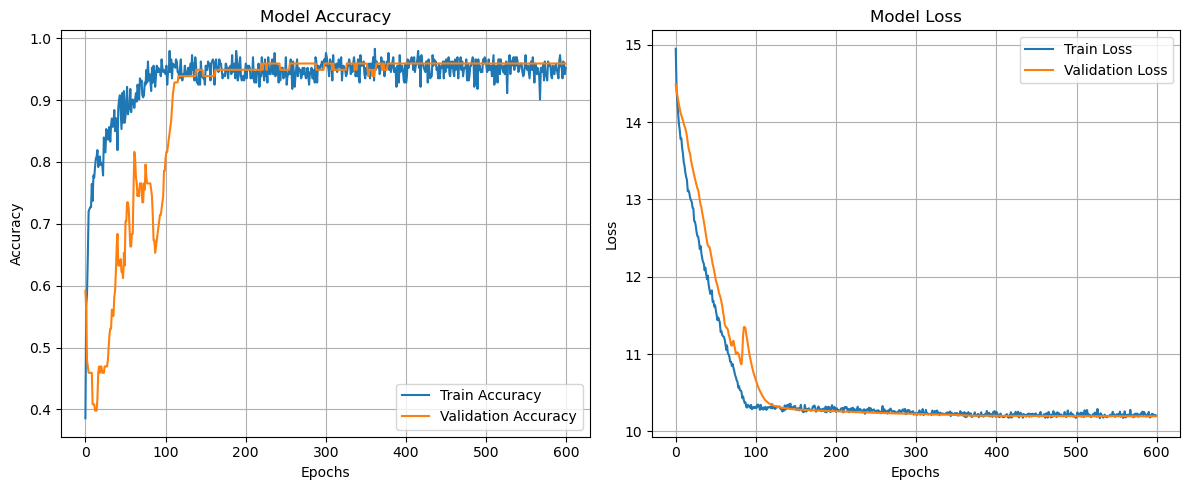

In [21]:

plot_learning_curves(history)


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight

# Hyperparameters
neurons_per_layer = 320
num_layers = 4
dropout_rate = 0.2
initializer = tf.keras.initializers.HeNormal()
l1_lambda = 0.00036499
l2_lambda = 0.0008163
learning_rate = 0.00013516

# Build the model with the specified hyperparameters
def create_ffnn_model(input_shape):
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=input_shape))
    model.add(Dense(neurons_per_layer, activation='relu', kernel_initializer=initializer, 
                    kernel_regularizer=l1_l2(l1_lambda, l2_lambda)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Hidden layers
    for _ in range(num_layers - 1):
        model.add(Dense(neurons_per_layer, activation='relu', kernel_initializer=initializer, 
                        kernel_regularizer=l1_l2(l1_lambda, l2_lambda)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    # Output layer (3 classes: OE, RE, TR)
    model.add(Dense(3, activation='softmax'))  # Assuming 3 classes for OE, RE, TR

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Assuming X_train has already been defined
input_shape = (X_train.shape[1],)  # Define input shape based on your data
model = create_ffnn_model(input_shape)

# Calculate class weights to handle class imbalance (if needed)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7)

# Train the model with the specified hyperparameters and callbacks
history = model.fit(X_train, y_train, epochs=600, validation_data=(X_val, y_val), batch_size=64, 
                    verbose=1, callbacks=[early_stopping, lr_scheduler], class_weight=class_weights)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Loss: {test_loss}')

# Predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate classification report (includes precision, recall, f1-score, and support)
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=["OE", "RE", "TR"]))

# Confusion Matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["OE", "RE", "TR"], yticklabels=["OE", "RE", "TR"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate F1-Score, Precision, and Recall
f1 = f1_score(y_true, y_pred_classes, average='weighted')
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')

print(f'Weighted F1-Score: {f1:.4f}')
print(f'Weighted Precision: {precision:.4f}')
print(f'Weighted Recall: {recall:.4f}')

# Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.show()


Epoch 1/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4098 - loss: 14.9422 - val_accuracy: 0.2959 - val_loss: 14.5859 - learning_rate: 1.3516e-04
Epoch 2/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5693 - loss: 14.4805 - val_accuracy: 0.3367 - val_loss: 14.5409 - learning_rate: 1.3516e-04
Epoch 3/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5413 - loss: 14.3766 - val_accuracy: 0.3571 - val_loss: 14.4826 - learning_rate: 1.3516e-04
Epoch 4/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6246 - loss: 14.2237 - val_accuracy: 0.3469 - val_loss: 14.4326 - learning_rate: 1.3516e-04
Epoch 5/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7012 - loss: 13.9358 - val_accuracy: 0.3469 - val_loss: 14.3737 - learning_rate: 1.3516e-04
Epoch 6/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7450 - loss: 13.7614 - val_accuracy: 0.3469 - val_loss: 14.3133 - learning_rate: 1.3516e-04
Epoch 7/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7

Epoch 44/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8875 - loss: 11.8406 - val_accuracy: 0.6327 - val_loss: 12.3175 - learning_rate: 1.3516e-04
Epoch 45/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9151 - loss: 11.7132 - val_accuracy: 0.6224 - val_loss: 12.2700 - learning_rate: 1.3516e-04
Epoch 46/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8900 - loss: 11.7087 - val_accuracy: 0.6020 - val_loss: 12.2289 - learning_rate: 1.3516e-04
Epoch 47/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8978 - loss: 11.7157 - val_accuracy: 0.6122 - val_loss: 12.1778 - learning_rate: 1.3516e-04
Epoch 48/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8917 - loss: 11.6792 - val_accuracy: 0.6327 - val_loss: 12.1267 - learning_rate: 1.3516e-04
Epoch 49/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8657 - loss: 11.6840 - val_accuracy: 0.5816 - val_loss: 12.1436 - learning_rate: 1.3516e-04
Epoch 50/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accur

Epoch 87/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9577 - loss: 10.3978 - val_accuracy: 0.8163 - val_loss: 10.6715 - learning_rate: 1.3516e-04
Epoch 88/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9457 - loss: 10.4022 - val_accuracy: 0.8163 - val_loss: 10.6457 - learning_rate: 1.3516e-04
Epoch 89/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9407 - loss: 10.3962 - val_accuracy: 0.8367 - val_loss: 10.5843 - learning_rate: 1.3516e-04
Epoch 90/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9476 - loss: 10.3317 - val_accuracy: 0.8367 - val_loss: 10.5377 - learning_rate: 1.3516e-04
Epoch 91/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9463 - loss: 10.3177 - val_accuracy: 0.8367 - val_loss: 10.5229 - learning_rate: 1.3516e-04
Epoch 92/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9314 - loss: 10.2944 - val_accuracy: 0.8367 - val_loss: 10.5121 - learning_rate: 1.3516e-04
Epoch 93/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accur

Epoch 130/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9639 - loss: 9.8608 - val_accuracy: 0.9082 - val_loss: 9.9875 - learning_rate: 1.3516e-06
Epoch 131/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9662 - loss: 9.8549 - val_accuracy: 0.9082 - val_loss: 9.9760 - learning_rate: 1.3516e-06
Epoch 132/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9569 - loss: 9.8707 - val_accuracy: 0.9184 - val_loss: 9.9661 - learning_rate: 1.3516e-06
Epoch 133/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9864 - loss: 9.8125 - val_accuracy: 0.9184 - val_loss: 9.9565 - learning_rate: 1.3516e-06
Epoch 134/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9602 - loss: 9.8474 - val_accuracy: 0.9286 - val_loss: 9.9480 - learning_rate: 1.3516e-06
Epoch 135/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9701 - loss: 9.8454 - val_accuracy: 0.9286 - val_loss: 9.9405 - learning_rate: 1.3516e-06
Epoch 136/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9625 - loss: 9.8323 - val_accuracy: 0.9694 - val_loss: 9.8290 - learning_rate: 1.3516e-06
Epoch 174/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9721 - loss: 9.8323 - val_accuracy: 0.9694 - val_loss: 9.8280 - learning_rate: 1.3516e-06
Epoch 175/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9589 - loss: 9.8729 - val_accuracy: 0.9796 - val_loss: 9.8272 - learning_rate: 1.3516e-06
Epoch 176/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9793 - loss: 9.8137 - val_accuracy: 0.9796 - val_loss: 9.8262 - learning_rate: 1.3516e-06
Epoch 177/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9613 - loss: 9.8314 - val_accuracy: 0.9796 - val_loss: 9.8257 - learning_rate: 1.3516e-06
Epoch 178/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9658 - loss: 9.8417 - val_accuracy: 0.9796 - val_loss: 9.8251 - learning_rate: 1.3516e-06
Epoch 179/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9386 - loss:

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9610 - loss: 9.8385 - val_accuracy: 0.9796 - val_loss: 9.8093 - learning_rate: 1.3516e-06
Epoch 217/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9714 - loss: 9.8308 - val_accuracy: 0.9796 - val_loss: 9.8092 - learning_rate: 1.3516e-06
Epoch 218/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9648 - loss: 9.8419 - val_accuracy: 0.9796 - val_loss: 9.8091 - learning_rate: 1.3516e-06
Epoch 219/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9761 - loss: 9.8269 - val_accuracy: 0.9796 - val_loss: 9.8087 - learning_rate: 1.3516e-06
Epoch 220/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9587 - loss: 9.8431 - val_accuracy: 0.9796 - val_loss: 9.8084 - learning_rate: 1.3516e-06
Epoch 221/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9630 - loss: 9.8230 - val_accuracy: 0.9796 - val_loss: 9.8079 - learning_rate: 1.3516e-06
Epoch 222/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9938 - loss:

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9638 - loss: 9.8165 - val_accuracy: 0.9796 - val_loss: 9.7986 - learning_rate: 1.3516e-06
Epoch 260/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9482 - loss: 9.8164 - val_accuracy: 0.9796 - val_loss: 9.7978 - learning_rate: 1.3516e-06
Epoch 261/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9700 - loss: 9.8206 - val_accuracy: 0.9796 - val_loss: 9.7977 - learning_rate: 1.3516e-06
Epoch 262/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9603 - loss: 9.8275 - val_accuracy: 0.9796 - val_loss: 9.7973 - learning_rate: 1.3516e-06
Epoch 263/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9681 - loss: 9.8091 - val_accuracy: 0.9796 - val_loss: 9.7970 - learning_rate: 1.3516e-06
Epoch 264/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9479 - loss: 9.8635 - val_accuracy: 0.9796 - val_loss: 9.7968 - learning_rate: 1.3516e-06
Epoch 265/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9422 - loss:

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9690 - loss: 9.7889 - val_accuracy: 0.9796 - val_loss: 9.7854 - learning_rate: 1.3516e-06
Epoch 303/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9508 - loss: 9.8002 - val_accuracy: 0.9796 - val_loss: 9.7851 - learning_rate: 1.3516e-06
Epoch 304/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9944 - loss: 9.7619 - val_accuracy: 0.9796 - val_loss: 9.7844 - learning_rate: 1.3516e-06
Epoch 305/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9669 - loss: 9.8018 - val_accuracy: 0.9796 - val_loss: 9.7844 - learning_rate: 1.3516e-06
Epoch 306/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9856 - loss: 9.7737 - val_accuracy: 0.9796 - val_loss: 9.7843 - learning_rate: 1.3516e-06
Epoch 307/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9882 - loss: 9.7875 - val_accuracy: 0.9796 - val_loss: 9.7840 - learning_rate: 1.3516e-06
Epoch 308/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9922 - loss:

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9574 - loss: 9.8020 - val_accuracy: 0.9796 - val_loss: 9.7733 - learning_rate: 1.3516e-06
Epoch 346/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9727 - loss: 9.7780 - val_accuracy: 0.9694 - val_loss: 9.7731 - learning_rate: 1.3516e-06
Epoch 347/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9772 - loss: 9.7717 - val_accuracy: 0.9694 - val_loss: 9.7727 - learning_rate: 1.3516e-06
Epoch 348/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9791 - loss: 9.7939 - val_accuracy: 0.9694 - val_loss: 9.7726 - learning_rate: 1.3516e-06
Epoch 349/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9563 - loss: 9.7974 - val_accuracy: 0.9694 - val_loss: 9.7724 - learning_rate: 1.3516e-06
Epoch 350/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9604 - loss: 9.7843 - val_accuracy: 0.9694 - val_loss: 9.7721 - learning_rate: 1.3516e-06
Epoch 351/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9732 - loss:

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9737 - loss: 9.7607 - val_accuracy: 0.9796 - val_loss: 9.7575 - learning_rate: 1.3516e-06
Epoch 389/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9682 - loss: 9.7612 - val_accuracy: 0.9796 - val_loss: 9.7573 - learning_rate: 1.3516e-06
Epoch 390/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9683 - loss: 9.7770 - val_accuracy: 0.9796 - val_loss: 9.7570 - learning_rate: 1.3516e-06
Epoch 391/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9630 - loss: 9.7730 - val_accuracy: 0.9796 - val_loss: 9.7568 - learning_rate: 1.3516e-06
Epoch 392/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9710 - loss: 9.7581 - val_accuracy: 0.9796 - val_loss: 9.7565 - learning_rate: 1.3516e-06
Epoch 393/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9643 - loss: 9.7771 - val_accuracy: 0.9796 - val_loss: 9.7561 - learning_rate: 1.3516e-06
Epoch 394/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9379 - loss:

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9691 - loss: 9.7586 - val_accuracy: 0.9796 - val_loss: 9.7426 - learning_rate: 1.3516e-06
Epoch 432/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9659 - loss: 9.7621 - val_accuracy: 0.9796 - val_loss: 9.7423 - learning_rate: 1.3516e-06
Epoch 433/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9780 - loss: 9.7517 - val_accuracy: 0.9796 - val_loss: 9.7418 - learning_rate: 1.3516e-06
Epoch 434/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9645 - loss: 9.7665 - val_accuracy: 0.9796 - val_loss: 9.7417 - learning_rate: 1.3516e-06
Epoch 435/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9809 - loss: 9.7604 - val_accuracy: 0.9796 - val_loss: 9.7415 - learning_rate: 1.3516e-06
Epoch 436/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9773 - loss: 9.7569 - val_accuracy: 0.9796 - val_loss: 9.7412 - learning_rate: 1.3516e-06
Epoch 437/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9888 - loss:

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9672 - loss: 9.7412 - val_accuracy: 0.9796 - val_loss: 9.7287 - learning_rate: 1.3516e-06
Epoch 475/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9775 - loss: 9.7526 - val_accuracy: 0.9796 - val_loss: 9.7282 - learning_rate: 1.3516e-06
Epoch 476/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9763 - loss: 9.7226 - val_accuracy: 0.9796 - val_loss: 9.7279 - learning_rate: 1.3516e-06
Epoch 477/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9729 - loss: 9.7348 - val_accuracy: 0.9796 - val_loss: 9.7281 - learning_rate: 1.3516e-06
Epoch 478/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9626 - loss: 9.7327 - val_accuracy: 0.9796 - val_loss: 9.7278 - learning_rate: 1.3516e-06
Epoch 479/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9591 - loss: 9.7522 - val_accuracy: 0.9796 - val_loss: 9.7277 - learning_rate: 1.3516e-06
Epoch 480/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9834 - loss:

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9751 - loss: 9.7280 - val_accuracy: 0.9796 - val_loss: 9.7172 - learning_rate: 1.3516e-06
Epoch 518/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9786 - loss: 9.7146 - val_accuracy: 0.9796 - val_loss: 9.7165 - learning_rate: 1.3516e-06
Epoch 519/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9739 - loss: 9.7247 - val_accuracy: 0.9796 - val_loss: 9.7159 - learning_rate: 1.3516e-06
Epoch 520/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9723 - loss: 9.7151 - val_accuracy: 0.9796 - val_loss: 9.7155 - learning_rate: 1.3516e-06
Epoch 521/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9604 - loss: 9.7191 - val_accuracy: 0.9796 - val_loss: 9.7149 - learning_rate: 1.3516e-06
Epoch 522/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9784 - loss: 9.7040 - val_accuracy: 0.9796 - val_loss: 9.7147 - learning_rate: 1.3516e-06
Epoch 523/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9710 - loss:

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9688 - loss: 9.7069 - val_accuracy: 0.9796 - val_loss: 9.6990 - learning_rate: 1.3516e-06
Epoch 561/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9759 - loss: 9.7078 - val_accuracy: 0.9796 - val_loss: 9.6985 - learning_rate: 1.3516e-06
Epoch 562/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9672 - loss: 9.7160 - val_accuracy: 0.9796 - val_loss: 9.6982 - learning_rate: 1.3516e-06
Epoch 563/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9654 - loss: 9.7221 - val_accuracy: 0.9796 - val_loss: 9.6976 - learning_rate: 1.3516e-06
Epoch 564/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9819 - loss: 9.6846 - val_accuracy: 0.9796 - val_loss: 9.6972 - learning_rate: 1.3516e-06
Epoch 565/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9764 - loss: 9.6905 - val_accuracy: 0.9796 - val_loss: 9.6968 - learning_rate: 1.3516e-06
Epoch 566/600
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9455 - loss:

AxisError: axis 1 is out of bounds for array of dimension 1

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Classification Report:
              precision    recall  f1-score   support

          OE       1.00      0.92      0.96        36
          RE       0.91      1.00      0.95        29
          TR       1.00      1.00      1.00        33

    accuracy                           0.97        98
   macro avg       0.97      0.97      0.97        98
weighted avg       0.97      0.97      0.97        98


Confusion Matrix:


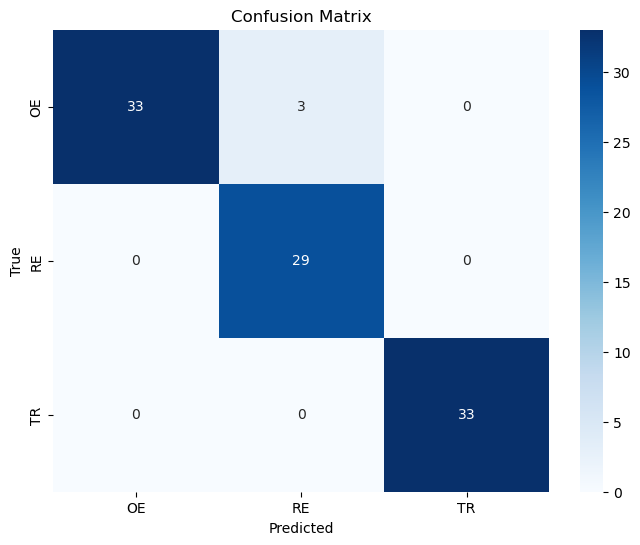

In [24]:
# Predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# No need to apply np.argmax to y_test if it's already in label format
y_true = y_test  # Assuming y_test is already a 1D array of labels

# Generate classification report (includes precision, recall, f1-score, and support)
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=["OE", "RE", "TR"]))

# Confusion Matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["OE", "RE", "TR"], yticklabels=["OE", "RE", "TR"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


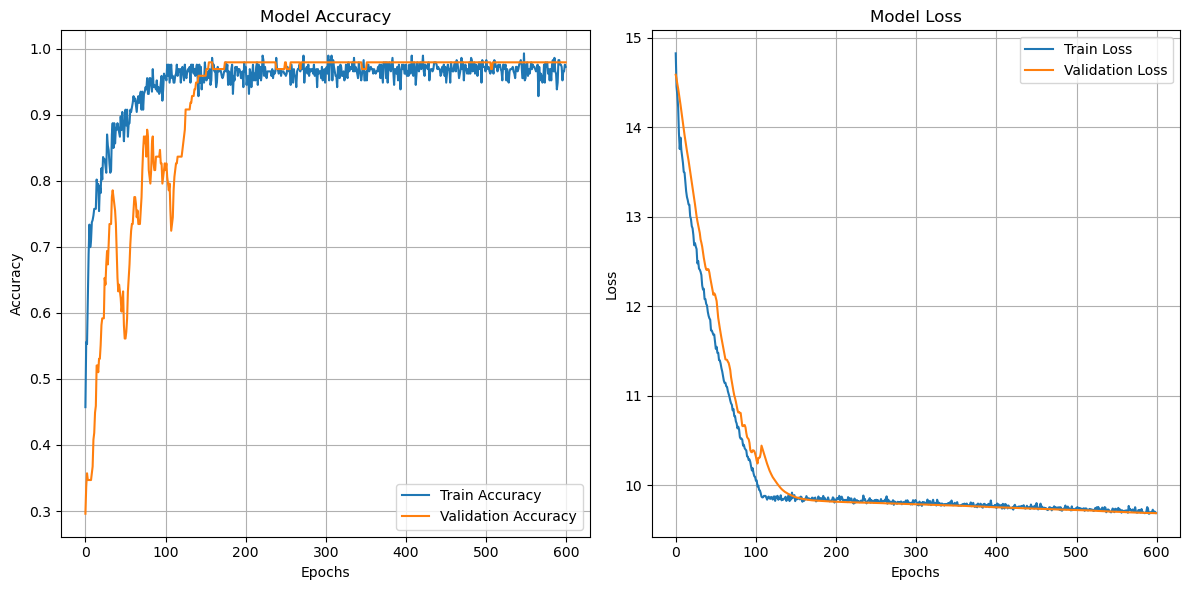

In [25]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    # Erstellen der Lernkurven für Genauigkeit und Verlust
    plt.figure(figsize=(12, 6))
    
    # Plot für die Genauigkeit
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Plot für den Verlust
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Lernkurven plotten
plot_learning_curves(history)
